In [523]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from time import time
from numba import jit
from scipy.linalg import lapack

# Numerical Linear Algebra

This notebook contains some examples from numerical linear algebra:
* A few examples of matrix operations
* Examples of sparse matrices
* Direct solvers for linear systems of equations
* Iterative solvers for linear systems of equations
* SVD and Eigenvalues

## Some basic operations

*Do not* write your own methods for, e.g., matrix multiplications. Many clever people have worked for many years giving us freely available and highly efficient tools for these tasks. Use them!

Just as an example, I implement matrix-matrix multiplication below, and compare the performance to numpy functions.

See also fortran example in ```../Fortran/BLAS/blas_example.f90```

In [64]:
from scipy.linalg.blas import dgemm, dgemv
from numba import njit

In [65]:
# Compiling this function with numba
# gains a speedup factor of 4 or so
@njit
def matrix_matrix_product(A, B):
    M, K = A.shape
    K, N = B.shape # overwriting K here, but it should have the same value
    # Creating output array of the correct shape
    C = np.empty((M, N))
    for i in range(M):
        for j in range(N):
            # Could use a third for-loop here,
            # but that would just be silly
            C[i,j] = np.sum(A[i,:] * B[:,j])
    return C


# Create some large-ish matrices
M = 1100
N = 1200
K = 1300

A = np.arange(1, M*K + 1, dtype=np.float64).reshape(M, K)
B = np.arange(1, K*N + 1, dtype=np.float64).reshape(K, N)

print('Naïve matrix-matrix multiplication')
%timeit C_naive = matrix_matrix_product(A, B)

print('Numpy matrix multiplication (np.dot)')
%timeit C_numpy = np.dot(A, B)

# dgemm is short for "Double precision GEneral Matrix-Matrix"
print('Using BLAS function dgemm directly via scipy.linalg.blas')
%timeit C_blas = dgemm(alpha=1.0, a=A, b=B)

Naïve matrix-matrix multiplication
5.23 s ± 67.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy matrix multiplication (np.dot)
23.3 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Using BLAS function dgemm directly via scipy.linalg.blas
34.2 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
C_naive = matrix_matrix_product(A, B)
C_numpy = np.dot(A, B)
C_blas = dgemm(alpha=1.0, a=A, b=B)

# Check that they actually produce the same results (to 15 digits)
print(f'C_naive == C_numpy: {np.allclose(C_naive, C_numpy, rtol = 1e-15)}')
print(f'C_naive == C_blas: {np.allclose(C_naive, C_blas, rtol = 1e-15)}')

C_naive == C_numpy: True
C_naive == C_blas: True


In [67]:
# Compiling this function with numba
# gains a speedup factor of 4 or so
@njit
def matrix_vector_product(A, B):
    M, K = A.shape
    # Creating output array of the correct shape
    C = np.empty(M)
    for i in range(M):
        # Could use a second for-loop here,
        # but that would just be silly
        C[i] = np.sum(A[i,:] * B[:])
    return C

# Create some large-ish matrices
M = 1100
K = 1300

A = np.arange(1, M*K + 1, dtype=np.float64).reshape(M, K)
B = np.arange(1, K + 1, dtype=np.float64)

print('Naïve matrix-vector multiplication')
%timeit C_naive = matrix_vector_product(A, B)

print('Numpy matrix-vector multiplication (np.dot)')
%timeit C_numpy = np.dot(A, B)

# dgemv is short for "Double precision GEneral Matrix-Vector"
print('Using BLAS function dgemv directly via scipy.linalg.blas')
%timeit C_blas = dgemv(alpha=1.0, a=A, x=B)

Naïve matrix-vector multiplication
2.33 ms ± 69 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy matrix-vector multiplication (np.dot)
178 µs ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Using BLAS function dgemv directly via scipy.linalg.blas
2.58 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Solving linear systems of equations with direct methods

Direct methods are most useful when you are dealing with dense matrices. A good place to start is ```np.linalg.solve```

https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

In [70]:
# Generate large equation system with known solution
N = 5000
# Note that a random matrix like this is _very_ unlikely to be singular, see
# https://math.stackexchange.com/questions/1872323/if-i-generate-a-random-matrix-what-is-the-probability-of-it-to-be-singular
A = np.random.random((N, N))
x = np.random.random(N)
b = np.dot(A, x)

# numpy.linalg.solve is a wrapper for the
# lapack routines sgesv, dgesv, cgesv and zgesv,
# which use LU decomposition.
# scipy.linalg contain other wrapped routines
# and scipy.linalg.lapack contains wrappers
# of individual lapack routines.
tic = time()
y = np.linalg.solve(A, b)
toc = time()
print(f'Solving took {toc - tic:.5f} seconds')
# Check that the solution matches
print(f'y == x: {np.allclose(x, y)}')

Solving took 0.67758 seconds
y == x: True


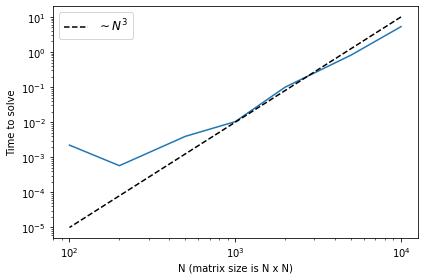

In [69]:
# Solve for a few different sizes and plot time
Ns = np.array([10000, 5000, 2000, 1000, 500, 200, 100])
Ts = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    # Create random equation system
    A = np.random.random((N, N))
    b = np.random.random(N)
    # Measure time and solve
    tic = time()
    y = np.linalg.solve(A, b)
    toc = time()
    # Store time
    Ts[i] = toc - tic

# Plot results
plt.plot(Ns, Ts)
# Add straight line (in log-log) to compare slope
plt.plot(Ns, 1e-11*np.array(Ns)**3, '--', c = 'k', label = '$\sim N^3$')
plt.legend(fontsize = 12)
plt.xlabel('N (matrix size is N x N)')
plt.ylabel('Time to solve')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

### Solving for multiple right-hand sides

With LU-decomposition, it is comparatively fast to solve for several right-hand sides once the system matrix has been LU-decomposed. ```np.linalg.solve()``` supports this feature by accepting several right-hand sides at once.

https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

In ```scipy.linalg``` you will also find methods to explicitly compute the LU decomposition, and to use that decomposition to solve equations:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html

In [564]:
# Note that np.linalg.solve is just a wrapper
# for lapack routines written in fortran, which
# solve equations using LU-decomposition.
# As a concequence, solving for multiple
# right-hand sides takes essentially no extra time.
N = 5000
A = np.random.random((N, N))
b = np.random.random(N)
c = np.random.random(N)
d = np.random.random(N)

tic = time()
x = np.linalg.solve(A, b)
toc = time()
print(f'Solving one system took  {toc-tic:.5f} seconds')

tic = time()
y = np.linalg.solve(A, np.array([b, c]).T)
toc = time()
print(f'Solving two systems took {toc-tic:.5f} seconds')

tic = time()
z = np.linalg.solve(A, np.array([b, c, d]).T)
toc = time()
print(f'Solving three systems took {toc-tic:.5f} seconds')

Solving one system took  1.08702 seconds
Solving two systems took 1.08485 seconds
Solving three systems took 1.13225 seconds


## Well-conditioned and ill-conditioned problems

Mathematically, a system of linear equations either has, or does not have, a solution. Numerically, we can have a situation where the properties of the matrix make it hard to find the solution with good accuracy. Such matrices/equation systems are called ill-conditioned, and the opposite is called well-conditioned.

We will look at some examples, using a geometric interpretation of a system of equations.

Consider the problem

$$ \mathbf{A} \mathbf{x} = \mathbf{b} $$

$$ \left[ \begin{array}{cc} A_{11} & A_{12} \\ A_{21} & A_{22} \end{array} \right]
\left[ \begin{array}{c} x_{1} \\ x_{2} \end{array} \right] = \left[ \begin{array}{c} b_{1} \\ b_{2} \end{array} \right] $$

This is equivalent to the geometric problem of finding the point where two straight lines in a plane intersect. There are three options:
* If the lines are *not* parallel, they intersect in exactly one point => System has one solution
* If they lines *are* parallel, there are two options:
 * They are identical, and intersect in all points => System has infinitely many solutions
 * They are not identical, and intersect in no points => System has no solutions

This generalises to higher dimensions as well, so three equations with three unknowns are equivalent to three planes in 3D space:
* If none of the planes are parallel, they intersect in exactly one point
* If all three planes are parallel and identical, there are infinitely many solutions
* If two of the planes are parallel, but not identcal, there are zero solutions
* If two planes are parallel and identical, and the third is not parallel to the first two, the planes intersect along a line, and again there are infinitely many solutions.

### A well-conditioned example

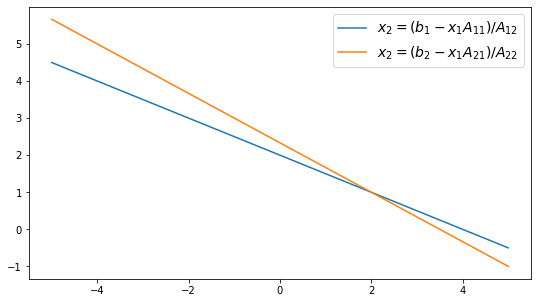

In [565]:
#Create a matrix and a vector
A = np.array([
        [1, 2],
        [2, 3]
    ])

b = np.array([
        [4.001],
        [6.999]
    ])

# Plot the two lines corresponding to the two equations.
# Geometric interpretation is that the solution is the point
# where the lines intersect
x1 = np.linspace(-5, 5, 2)
fig = plt.figure(figsize = (9, 5))
plt.plot(x1, (b[0] - x1*A[0,0]) / A[0,1], label = '$x_2 = (b_1 - x_1 A_{11}) / A_{12}$')
plt.plot(x1, (b[1] - x1*A[1,0]) / A[1,1], label = '$x_2 = (b_2 - x_1 A_{21}) / A_{22}$')
plt.legend(fontsize = 14)

In [567]:
# We observe that the slope of the lines are determined by A
# while the values of b serve to move the lines up and down,
# thus moving their point of intersection.

# With a well conditioned system, a small change in b
# leads to a small change in x
#Create a matrix and a vector
A = np.array([
        [1, 2],
        [2, 3]
    ])

b1 = np.array([4.0, 7.0]).T
b2 = np.array([4.0, 6.999]).T

print(f'Solution for b1: {np.linalg.solve(A, b1)}')
print(f'Solution for b2: {np.linalg.solve(A, b2)}')

Solution for b1: [2. 1.]
Solution for b2: [1.998 1.001]


In [568]:
# Condition number gives an indication
# Large condition number => Ill-conditioned problem
np.linalg.cond(A)

17.94427190999918

### An ill-conditioned example

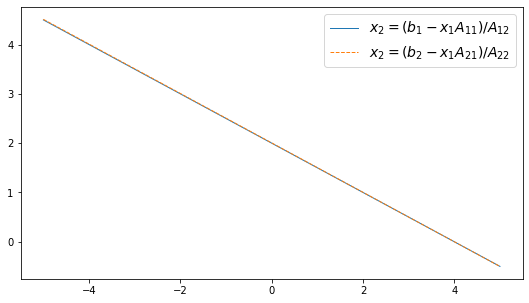

In [651]:
# This is an example of an equation system
# which is ill-conditioned, meaning that
# a small change in the equations will lead
# to a large change in x

A = np.array([
        [1, 2    ],
        [2, 3.99] # adjust this number to make the lines more or less parallel
    ])

b = np.array([
        [4.0],
        [8.0]
    ])

# Plot the two lines corresponding to the two equations.
# Geometric interpretation is that the solution is the point
# where the lines intersect, and when the lines are very nearly
# parallel, moving either line up or down (which corresponds to
# changing the right-hand side, b) leads to a large change in
# the solution
x1 = np.linspace(-5, 5, 2)
fig = plt.figure(figsize = (9, 5))
plt.plot(x1, (b[0] - x1*A[0,0]) / A[0,1], label = '$x_2 = (b_1 - x_1 A_{11}) / A_{12}$', lw = 1)
plt.plot(x1, (b[1] - x1*A[1,0]) / A[1,1], '--', label = '$x_2 = (b_2 - x_1 A_{21}) / A_{22}$', lw = 1)
plt.legend(fontsize = 14)

In [573]:
# We observe that the slope of the lines are determined by A
# while the values of b serve to move the lines up and down,
# thus moving their point of intersection.

# With a well conditioned system, a small change in b
# leads to a small change in x

# Create a matrix and a vector
A = np.array([
        [1, 2    ],
        [2, 3.99999]
    ])

b1 = np.array([4.0, 8.0]).T
b2 = np.array([4.0, 8.01]).T

print(f'Solution for b1: {np.linalg.solve(A, b1)}')
print(f'Solution for b2: {np.linalg.solve(A, b2)}')

Solution for b1: [4. 0.]
Solution for b2: [2003.99999999 -999.99999999]


In [574]:
# Condition number gives an indication
# Large condition number => Ill-conditioned problem
np.linalg.cond(A)

2499992.0003352966

## Sparse matrices

Quite frequently in physical problems, we end up with so-called sparse matrices (Norwegian: "glisne matriser"). These are matrices that have many (sometimes most) of their elements equal to 0. The opposite of a sparse matrix is a dense matrix (Norwegian: "tette matriser").

A physical intuition for why this occurs, at least in some cases, is that the matrix element $i,j$ describes the interaction between object $i$ and object $j$. If objects only interact with, e.g., their neighbours, this will lead to only a few non-zero elements.

SciPy has support for a few different ways of storing sparse matrices. The point is to avoid storing (and operating on) all the zeros, thus saving memory and time. Depending on the structure of the matrix, some formats will be more efficient than others, and not all formats support all operations. We cannot go through everything here, hence experimentation (and reading documentation) is encouraged.

https://docs.scipy.org/doc/scipy/reference/sparse.html

We will get back to sparse matrices several times later, when talking about iterative methods for linear systems of equations, and when discussing PDE solvers.

In [579]:
# Simple example: Create a sparse matrix with three diagonals
# (typical occurence: 1D diffusion problem)
from scipy.sparse import diags

N = 10
a = 0.1
super_diagonal = np.zeros(N-1) + a
main_diagonal = np.ones(N) - a
sub_diagonal = np.zeros(N-1) + a
A = diags([super_diagonal, main_diagonal, sub_diagonal], offsets = [1, 0, -1])

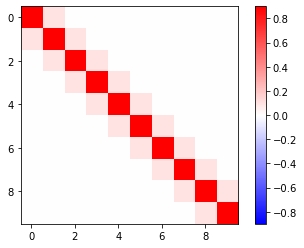

In [580]:
# Plot for illustration
# Note the use of the method .todense()
# which is necessary to return the full matrix
vmax = np.amax(A.todense())
plt.imshow(A.todense(), cmap = plt.cm.bwr, vmin = -vmax, vmax = vmax)
plt.colorbar()

In [652]:
# Create a larger diagonal matrix, and compare speed of matrix-vector product
N = 1000
a = 0.1
super_diagonal = np.zeros(N-1) + a
main_diagonal = np.ones(N) - a
sub_diagonal = np.zeros(N-1) + a
A = diags([super_diagonal, main_diagonal, sub_diagonal], offsets = [1, 0, -1])

C = np.linspace(0, 1, N)

print('Matrix-vector product using .dot() method on sparse matrix')
%timeit A.dot(C)

A_dense = A.todense()

print('Matrix-vector product using np.dot()')
%timeit np.dot(A_dense, C)

Matrix-vector product using .dot() method on sparse matrix
5.78 µs ± 197 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Matrix-vector product using np.dot()
111 µs ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Thomas algorithm: A direct method for tridiagonal matrices

Tri-diagonal matrices can occur for example in one-dimensional PDE problems, where you have a number of points along a grid, and we use a finite difference scheme to approximate the spatial derivative. Another example where a tridiagonal equation system occurs is to find a cubic spline interpolation in one dimension.

For tridiagonal equation systems, there exists a direct algorithm that will find the solution in time proportional to $N$. For comparison, we saw above that LU decomposition took time proportional to $N^3$. This algorithm is called the Thomas algorithm, or the tri-diagonal matrix algorithm (TDMA). 

An important point is that this matrix is not always guaranteed to work, but it works if the matrix is diagonally dominant. This happen to be the case for, e.g., solving the diffusion equation.

See https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm and http://folk.ntnu.no/leifh/teaching/tkt4140/._main040.html

In [653]:
# Compiling this function with numba gains a speedup
# of about a factor 10 - 100 (depends on problem size)
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    # Make to extra arrays to avoid overwriting input
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        q = (b[i] - a[i-1]*c_[i-1])
        c_[i] = c[i]/q
        d_[i] = (d[i] - a[i-1]*d_[i-1])/q
    d_[N-1] = (d[N-1] - a[N-2]*d_[N-2])/(b[N-1] - a[N-2]*c_[N-2])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse array structure into separate diagonals,
    # and passes them to the numba-compiled solver defined above.
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

In [654]:
N = 1000

# Create a random equation system, and compute the solution
A = diags((np.random.random(N-1), 3  + 10*np.random.random(N), np.random.random(N-1)), offsets = (-1, 0, 1))
x = np.random.random(N)
b = A.dot(x)

# Calculate solution with both TDMA and LU decomposition
x_tdma = tdma(A, b)
x_numpy = np.linalg.solve(A.todense(), b)

# Check that solutions are both equal to x
print('TDMA solution equal to x: ', np.allclose(x, x_tdma))
print('NumPy solution equal to x:', np.allclose(x, x_numpy))

TDMA solution equal to x:  True
NumPy solution equal to x: True


In [656]:
# Compare timing
# Recall that LU decomposition scales like N^3,
# while TDMA scales like N.
%timeit x = tdma(A, b)
%timeit x_numpy = np.linalg.solve(A.todense(), b)

24.1 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.8 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Also testing dgttrf/dgttrs from LAPACK

Lapack contains solvers for tridiagonal systems as well, and these are accessibly through a pair of poorly documented scipy routines:
* First, call `dgttrf` to compute LU-decomposition (which is fast to do for a tridiagonal matrix)
* Then, call `dgttrs` to solve, based on the LU-decpomposition computed previously

Recall that routines starting with d is for double precision. Replace with `sgttrf`/`sgtrrs` for single precision, `cgttrf`/`cgtrrs` for single complex, etc.

See "documentation" in SciPy pages:
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lapack.dgttrf.html#scipy.linalg.lapack.dgttrf
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lapack.dgttrs.html#scipy.linalg.lapack.dgttrs


And perhaps more usefully, see the LAPACK documentation directly:
* http://www.netlib.org/lapack/lapack-3.1.1/html/dgttrf.f.html
* http://www.netlib.org/lapack/lapack-3.1.1/html/dgttrs.f.html

In [657]:
from scipy.linalg.lapack import dgttrf, dgttrs

In [658]:
N = 1000

# Create a random equation system, and compute the solution
A = diags((np.random.random(N-1), 3  + 10*np.random.random(N), np.random.random(N-1)), offsets = (-1, 0, 1))
x = np.random.random(N)
b = A.dot(x)

# First, compute LU decomposition with dgttrf
# (recall that d is double precision, so replace as needed)
tic = time()
dl, dm, du, du2, ipiv, info = dgttrf(A.diagonal(-1), A.diagonal(0), A.diagonal(1))
#print(f'info = {info} (0 means successful result)')
# Then, solve with dgttrs based on decpomposition
x_lapack, info = dgttrs(dl, dm, du, du2, ipiv, b.reshape((N,1)))
#print(f'info = {info} (0 means successful result)')
toc = time()
print('dgttrf/dgttrs took ', toc - tic , ' seconds')
# Remove extra dimension
x_lapack = np.squeeze(x_lapack)

print('LAPACK solution equal to x: ', np.allclose(x, x_lapack))

dgttrf/dgttrs took  0.0004341602325439453  seconds
LAPACK solution equal to x:  True


# Example of application: 1D diffusion equation (explicit solver)

The diffusion equation in 1D, for constant diffusivity $K$, and a concentration $C(z, t)$, reads

$$ \frac{\partial C}{\partial t} = K \frac{\partial^2 C}{\partial z^2} $$

We discretise space and time such that

$$ z_n = z_0 + n \Delta z, \;\;\;\; t_i = t_0 + i \Delta t, $$

and we introduce the shorthand notation

$$ C_n^i = C(z_n, t_i). $$

If we discretise the derivatives with finite differences (forward finite difference in time, central finite difference in space, details to follow later in the course when we get to PDEs), we get

$$ C_n^{i+1} = C_n^{i} + K \Delta t \frac{ C_{n+1}^i - 2 C_n^i + C_{n-1}^i }{\Delta z^2} $$.

Introducing the variable $\alpha = K\frac{\Delta t}{\Delta z^2}$, we can write this as a matrix-vector multiplication:

$$ \left[ \begin{array}{c} C_0^{i+1} \\ C_1^{i+1} \\ \vdots \\C_{n-1}^{i+1} \\ C_n^{i+1} \\C_{n+1}^{i+1} \\ \vdots \\ C_{N-1}^{i+1} \\C_N^{i+1} \end{array}\right] 
= \left[ \begin{array}{ccccccccc}
1 - 2\alpha & \alpha &0&&\cdots&&0&0&0 \\
\alpha & 1-2\alpha & \alpha&0&&&&0&0 \\
 &&&&&&&& 0 \\
 &0& \alpha & 1-2\alpha & \alpha &0&&& \\
\vdots &&0& \alpha & 1-2\alpha & \alpha &0&&\vdots \\
 &&&0& \alpha & 1-2\alpha & \alpha &0& \\
0&&&&&&&& \\
0&0&&& &0& \alpha & 1-2\alpha & \alpha\\
0&0&0&&\cdots& &0& \alpha & 1-2\alpha \\
\end{array}\right]
\left[ \begin{array}{c} C_0^{i} \\ C_1^{i} \\ \vdots \\C_{n-1}^{i} \\ C_n^{i} \\C_{n+1}^{i} \\ \vdots \\ C_{N-1}^{i} \\C_N^{i} \end{array}\right] $$

In [659]:
# Problem parameters
N  = 499
Zmax = 1
dt = 0.0002
Tmax = 2
K  = 0.01
# Z axis:
zc = np.linspace(0, Zmax, N+1)
dz = zc[1] - zc[0]
# Number of timesteps
Nt = int(Tmax/dt)

# Set up matrix for the right-hand side,
# using sparse diagonal matrix structure
alpha = K*dt/dz**2
sub_diag = alpha * np.ones(N) 
main_diag = 1 - 2*alpha * np.ones(N+1)
super_diag = alpha * np.ones(N) 
R = diags((sub_diag, main_diag, super_diag), offsets = (-1, 0, 1))

# Check stability condition for this method (alpha < 1/2)
if alpha > 0.5:
    print(f'alpha = {alpha}, must be <= 1/2 for stability')

Loop over timesteps took 0.0609 seconds


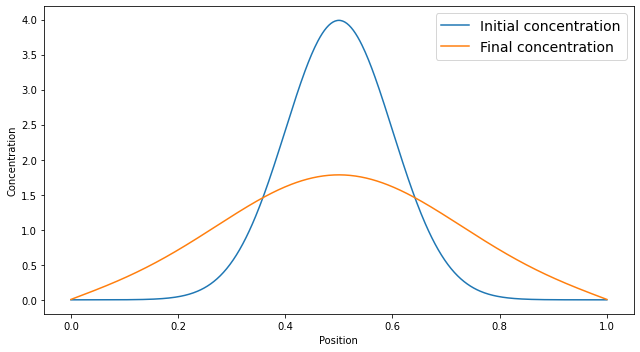

In [660]:
# Initial concentration
mu = 0.5
sigma = 0.1
C = np.exp(-(zc - mu)**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))

# Plot initial concentration
fig = plt.figure(figsize = (9, 5))
plt.plot(zc, C, label = 'Initial concentration')

# Loop over time, taking matrix-vector product at ecah timestep
tic = time()
for i in range(Nt):
    C = R.dot(C)
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')

# Plot concentration at t = Tmax
plt.plot(zc, C, label = 'Final concentration')
plt.legend(fontsize = 14)
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.tight_layout()

# Example of application: 1D diffusion equation (implicit solver)

Using the same notation as above, we now discretise the diffusion equation with an implicit method in time, where we calculate the time-derivative based on the average of the concentration at times $t_i$ and $t_{i+1}$. Since we do not yet know the concentration at time $t_{i+1}$, this leads to an implicit method where we have to solve a system of equations. (Again, we will go through this in more detail when we get to PDE methods in a couple of weeks).

With the same notation as before, we get

$$ C_n^{i+1} = C_n^{i} + \frac{K \Delta t }{2} \left[ \frac{ C_{n+1}^i - 2 C_n^i + C_{n-1}^i }{\Delta z^2} +  \frac{ C_{n+1}^{i+1} - 2 C_n^{i+1} + C_{n-1}^{i+1} }{\Delta z^2} \right] $$.

Introducing the variable $\alpha = \frac{1}{2}K\frac{\Delta t}{\Delta z^2}$, we can write this as a system of linear equations:

$$ \left[ \begin{array}{ccccccccc}
1 + 2\alpha & -\alpha &0&&\cdots&&0&0&0 \\
-\alpha & 1+2\alpha & -\alpha&0&&&&0&0 \\
 &&&&&&&& 0 \\
 &0& -\alpha & 1+2\alpha & -\alpha &0&&& \\
\vdots &&0& -\alpha & 1+2\alpha & -\alpha &0&&\vdots \\
 &&&0& -\alpha & 1+2\alpha & -\alpha &0& \\
0&&&&&&&& \\
0&0&&& &0& -\alpha & 1+2\alpha & -\alpha\\
0&0&0&&\cdots& &0& -\alpha & 1+2\alpha \\
\end{array}\right]
\left[ \begin{array}{c} C_0^{i+1} \\ C_1^{i+1} \\ \vdots \\C_{n-1}^{i+1} \\ C_n^{i+1} \\C_{n+1}^{i+1} \\ \vdots \\ C_{N-1}^{i+1} \\C_N^{i+1} \end{array}\right] \\
= \left[ \begin{array}{ccccccccc}
1 - 2\alpha & \alpha &0&&\cdots&&0&0&0 \\
\alpha & 1-2\alpha & \alpha&0&&&&0&0 \\
 &&&&&&&& 0 \\
 &0& \alpha & 1-2\alpha & \alpha &0&&& \\
\vdots &&0& \alpha & 1-2\alpha & \alpha &0&&\vdots \\
 &&&0& \alpha & 1-2\alpha & \alpha &0& \\
0&&&&&&&& \\
0&0&&& &0& \alpha & 1-2\alpha & \alpha\\
0&0&0&&\cdots& &0& \alpha & 1-2\alpha \\
\end{array}\right]
\left[ \begin{array}{c} C_0^{i} \\ C_1^{i} \\ \vdots \\C_{n-1}^{i} \\ C_n^{i} \\C_{n+1}^{i} \\ \vdots \\ C_{N-1}^{i} \\C_N^{i} \end{array}\right] $$

In [661]:
# Problem parameters
N  = 499
Zmax = 1
dt = 0.5 # Note that the implicit method allows a far longer timestep
Tmax = 2
K  = 0.01
# Z axis:
zc = np.linspace(0, Zmax, N+1)
dz = zc[1] - zc[0]
# Number of timesteps
Nt = int(Tmax/dt)

# Set up matrix for the right-hand side,
# using sparse diagonal matrix structure
alpha = 0.5*K*dt/dz**2
sub_diag = alpha * np.ones(N)
main_diag = 1 - 2*alpha * np.ones(N+1)
super_diag = alpha * np.ones(N)
R = diags((sub_diag, main_diag, super_diag), offsets = (-1, 0, 1))
# Using symmetry to set up L based on diagonals of R
# (see equations above)
L = diags((-sub_diag, 2 - main_diag, -super_diag), offsets = (-1, 0, 1))

Loop over timesteps took 0.0004 seconds


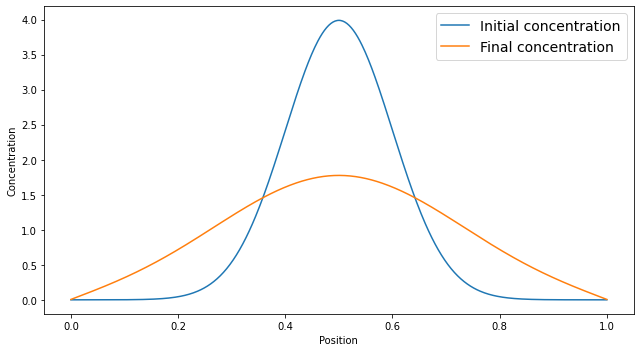

In [662]:
# Initial concentration
mu = 0.5
sigma = 0.1
C = np.exp(-(zc - mu)**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))

# Plot initial concentration
fig = plt.figure(figsize = (9, 5))
plt.plot(zc, C, label = 'Initial concentration')

# Loop over time
tic = time()
for i in range(Nt):
    # First, calculate matrix-vector product on right-hand side
    x = R.dot(C)
    # Then, solve equation system on left-hand side
    C = tdma(L, x)
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')

# Plot concentration at t = Tmax
plt.plot(zc, C, label = 'Final concentration')
plt.legend(fontsize = 14)
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.tight_layout()

# But what about the inverse?

In the example above, we had an equation system of the form

$$ \mathbf{L} \mathbf{C}^{i+1} = \mathbf{R} \mathbf{C}^i, $$

where $\mathbf{L}$ and $\mathbf{R}$ are matrices. So how about calculating the inverse of $\mathbf{L}$, obtaining the explicit system

$$ \mathbf{C}^{i+1} = \mathbf{L}^{-1} \mathbf{R} \mathbf{C}^i. $$

While this might work, there are two reasons you may want to avoid this:
* It is not always stable (see https://arxiv.org/abs/1201.6035 )
* It is not always faster (see below)

In [663]:
# Problem parameters
N  = 499
Zmax = 1
dt = 0.5 # Note that the implicit method allows a far longer timestep
Tmax = 2
K  = 0.01
# Z axis:
zc = np.linspace(0, Zmax, N+1)
dz = zc[1] - zc[0]
# Number of timesteps
Nt = int(Tmax/dt)

# Set up matrix for the right-hand side,
# using sparse diagonal matrix structure
alpha = 0.5*K*dt/dz**2
sub_diag = alpha * np.ones(N)
main_diag = 1 - 2*alpha * np.ones(N+1)
super_diag = alpha * np.ones(N)
R = diags((sub_diag, main_diag, super_diag), offsets = (-1, 0, 1))
# Using symmetry to set up L based on diagonals of R
# (see equations above)
L = diags((-sub_diag, 2 - main_diag, -super_diag), offsets = (-1, 0, 1))
# Find inverse of L
Linv = np.linalg.inv(L.todense())

Loop over timesteps took 0.0005 seconds


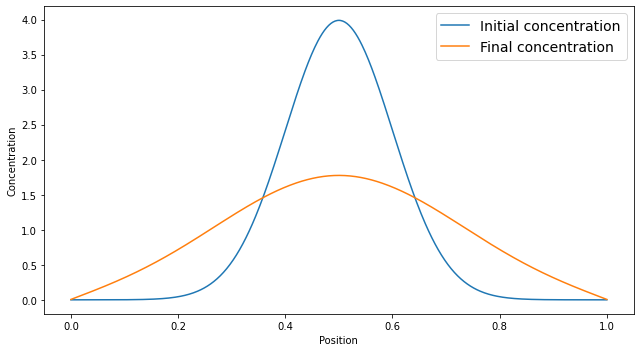

In [664]:
# Initial concentration
mu = 0.5
sigma = 0.1
C = np.exp(-(zc - mu)**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))

# Plot initial concentration
fig = plt.figure(figsize = (9, 5))
plt.plot(zc, C, label = 'Initial concentration')

# Loop over time
tic = time()
for i in range(Nt):
    # First, calculate matrix-vector product R*C
    # Then, calculate matrix-vector product Linv*(R*C)
    # For some reason np.dot returns an np.matrix instead of an np.array,
    # which causes trouble, so converting this back to 1D array
    C = np.array(np.dot(Linv, R.dot(C))).flatten()
toc = time()
print(f'Loop over timesteps took {toc - tic:.4f} seconds')

# Plot concentration at t = Tmax
plt.plot(zc, C, label = 'Final concentration')
plt.legend(fontsize = 14)
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.tight_layout()

# Visualising matrices

In the example above, an issue is that the inverse of a sparse matrix is not necessarily sparse itself. Therefore, calculating $\mathbf{C}^{i+1} = \mathbf{L}^{-1} \mathbf{R} \mathbf{C}^i$ is simply slower than solving the equation system $ \mathbf{L} \mathbf{C}^{i+1} = \mathbf{R} \mathbf{C}^i$. However, this will depend on the nature of the matrix $\mathbf{L}$.

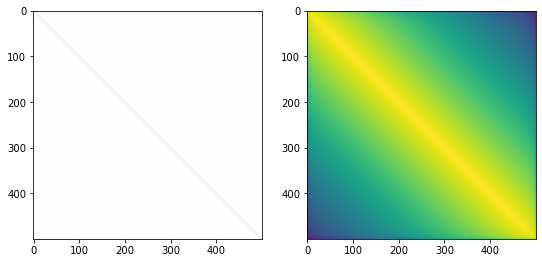

In [665]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 5))

vmax = np.amax(L.todense())
ax[0].imshow(L.todense(), cmap = plt.cm.bwr, vmin = -vmax, vmax = vmax)
# Plotting log10 her to make it more visible that Linv is dense
ax[1].imshow(np.log10(Linv))

# Iterative methods

While *direct methods* aim to find the correct solution in a finite (and sometimes fixed) number of steps, *iterative methods* aim to find an approximate solution, which is improved by additional iterations until some tolerance is satisfied.

Say that we want to solve the system $g(\mathbf{x}) = 0$. The idea is to start from an initial guess at the solution, $\mathbf{x}_ 0$, and then apply an iterative scheme

$$ \mathbf{x}^{i+1} = f(\mathbf{x}^i) $$

which is such that $\mathbf{x}^i \to \mathbf{x}$ as $i \to \infty$. In practice, we stop the iterations based on some measure of the convergence, for example when the change between successive iterations is small

$$ \frac{ || \mathbf{x}^{i+1} -\mathbf{x}^{i} ||}{|| \mathbf{x}^{i+1} ||} < \mathrm{tol},$$

or when the *residual* is small enough

$$  || \mathbf{b} -\mathbf{Ax}^{i} || < \mathrm{tol}.$$

## Jacobi method

(see details on slides)

In [666]:
def jacobi(A, b, x0, tol = 1e-9):
    # Split A into diagonal and off-diagonal
    I = np.identity(A.shape[0])
    D = A * I # Elementwise multiplication
    # Find E = L + U, since these are only used together as (L+U)
    E = A - D # A - diagonal = off-diagonal
    # Calculate inverse of D
    # (easy since D is diagonal)
    Dinv = np.diag(1/np.diag(D))
    # Calculate B and z once
    B = -np.dot(Dinv, E) # E = L + U
    z =  np.dot(Dinv, b)
    # Store residuals in a list for plotting purposes
    res = np.linalg.norm(b - np.dot(A, x0))
    residuals = [res]
    while res > tol:
        x0 = np.dot(B, x0) + z
        res = np.linalg.norm(b - np.dot(A, x0))
        residuals.append(res)
    return x0, np.array(residuals)

Solution matches: True


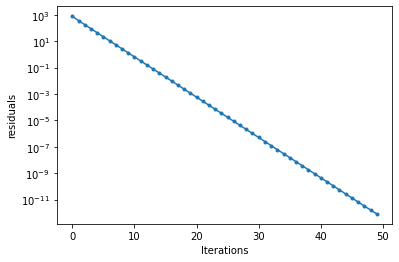

In [667]:
N = 100
# Create a symmetric positive definite diagonally dominant matrix
# (which means Jacobi is guaranteed to converge)
A = np.random.random((N, N))
A = np.diag(N*np.ones(N)) + (A + A.T)/2
x = np.random.random(N)
b = A.dot(x)

x_jacobi, res_jacobi = jacobi(A, b, np.ones(N), tol = 1e-12)

# Confirm that solution matches the correct x
print(f'Solution matches: {np.allclose(x, x_jacobi)}')

# Plot series of residuals
plt.plot(res_jacobi, marker = '.')
plt.xlabel('Iterations')
plt.ylabel('residuals')
plt.yscale('log')

## Gauss-Seidel

(see details on slides)

In [668]:
def gaussSeidel(A, b, x0, tol = 1e-9):
    I = np.identity(A.shape[0])
    D = A*I # Elementwise multiplication
    L = np.tril(A, k = -1)
    U = np.triu(A, k =  1)
    # Calculate inverse of D+L, using a lapack routine
    # specific for triangular matrices.
    # lower = 0 would indicate an upper triangular matrix.
    # info =! 0 indicates something went wrong.
    Li, info = lapack.dtrtri(D+L, lower = 1)
    G  = -np.dot(Li, U)
    z  =  np.dot(Li, b)
    res = np.linalg.norm(b - np.dot(A, x0))
    residuals = [res]
    while res > tol:
        x0 = np.dot(G, x0) + z
        res = np.linalg.norm(b - np.dot(A, x0))
        residuals.append(res)
    return x0, np.array(residuals)

Solution matches: True


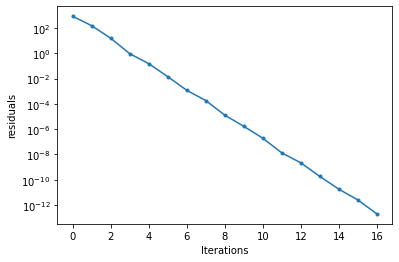

In [625]:
N = 100
# Create a symmetric positive definite diagonally dominant matrix
A = np.random.random((N, N))
A = np.diag(N*np.ones(N)) + (A + A.T)/2
x = np.random.random(N)
b = A.dot(x)

x_GS, res_GS = gaussSeidel(A, b, np.ones(N), tol = 1e-12)

# Confirm that solution matches the correct x
print(f'Solution matches: {np.allclose(x, x_GS)}')

# Plot series of residuals
plt.plot(res_GS, marker = '.')
plt.xlabel('Iterations')
plt.ylabel('residuals')
plt.yscale('log')

## Successive over-relaxation (SOR)

(see details on slides)

In [669]:
def SOR(A, b, x0, tol = 1e-9, w = 1.5):
    I = np.identity(A.shape[0])
    D = A*I # Elementwise multiplication
    L = np.tril(A, k = -1)
    U = np.triu(A, k =  1)
    Li, info = lapack.dtrtri(D + w*L, lower = 1)
    S = np.dot(-Li, w*U + (w-1)*D)
    z = np.dot(Li, w*b)
    res = np.linalg.norm(b - np.dot(A, x0))
    residuals = [res]
    while res > tol:
        x0 = np.dot(S, x0) + z
        res = np.linalg.norm(b - np.dot(A, x0))
        residuals.append(res)
    return x0, np.array(residuals)

Solution matches: True


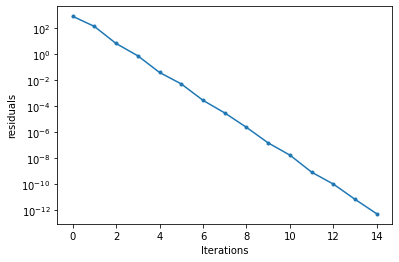

In [633]:
N = 100
# Create a symmetric positive definite diagonally dominant matrix
A = np.random.random((N, N))
A = np.diag(N*np.ones(N)) + (A + A.T)/2
x = np.random.random(N)
b = A.dot(x)

x_SOR, res_SOR = SOR(A, b, np.ones(N), tol = 1e-12, w = 0.95)

# Confirm that solution matches the correct x
print(f'Solution matches: {np.allclose(x, x_SOR)}')

# Plot series of residuals
plt.plot(res_SOR, marker = '.')
plt.xlabel('Iterations')
plt.ylabel('residuals')
plt.yscale('log')

# Compare the three methods, using 1D Poisson equation as example

$$ \frac{\partial^2 \phi }{ \partial x^2} = s(x), $$

here using

$$ s(x) = x(x+3) \mathrm{e}^x, $$

and boundary conditions $\phi(0) = \phi(1) = 0$.

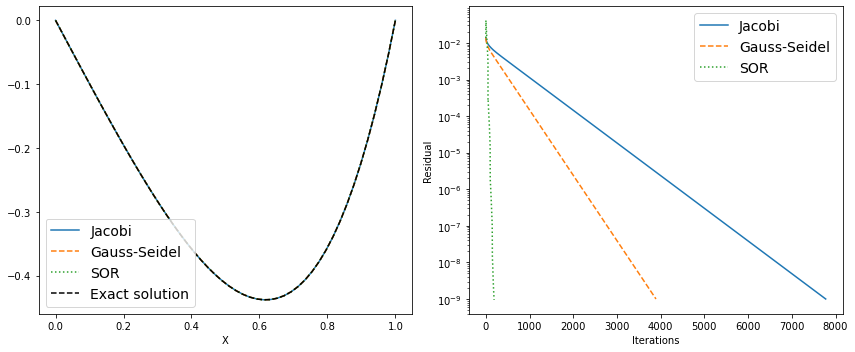

In [648]:
def s(x):
    return x*(x+3)*np.exp(x)

# Decide on discretisation, construct vector of x-values
N  = 50
x  = np.linspace(0, 1, N)
dx = x[1] - x[0]

# Construct A, begin by tridiagonal matrix
# with 2 on diagonal and -1 on the two off-diagonals
# Note that this example explicitly handles the endpoints,
# unlike the example in the slides
A = np.diag(2*np.ones(N)) - np.diag(np.ones(N-1), -1) - np.diag(np.ones(N-1), +1)
# Fix first and last rows to take care of boundary conditions
A[ 0, 0] = 1
A[ 0, 1] = 0
A[-1,-1] = 1
A[-1,-2] = 0

# Construct b
b = -dx**2 * s(x)
# Set first and last element to take care of boundary conditions
# Change these to try different boundary conditions
b[0]  = 0
b[-1] = 0

# Initial guess at phi
phi0 = np.zeros(N)

# Solve using different methods
tol = 1e-9
phi_jac, res_jac = jacobi(      A, b, phi0, tol = tol )
phi_GS,  res_GS  = gaussSeidel( A, b, phi0, tol = tol )
phi_SOR, res_SOR = SOR(         A, b, phi0, tol = tol, w = 1.9 )

# Plot comparison
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
ax[0].plot(x, phi_jac, label = 'Jacobi')
ax[0].plot(x, phi_GS, '--', label = 'Gauss-Seidel')
ax[0].plot(x, phi_SOR, ':', label = 'SOR')
ax[0].plot(x, x*(x-1)*np.exp(x), '--', c = 'k', label = 'Exact solution')

ax[1].plot(res_jac, label = 'Jacobi')
ax[1].plot(res_GS, '--', label = 'Gauss-Seidel')
ax[1].plot(res_SOR, ':', label = 'SOR')
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Iterations')
ax[0].set_xlabel('X')
ax[1].set_yscale('log')
ax[0].legend(loc = 'lower left', fontsize = 14)
ax[1].legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()

In [649]:
# Check number of iterations
print(f'Number of iterations with Jacobi: {len(res_jac)}')
print(f'Number of iterations with Gauss-Seidel: {len(res_GS)}')
print(f'Number of iterations with SOR: {len(res_SOR)}')

Number of iterations with Jacobi: 7776
Number of iterations with Gauss-Seidel: 3893
Number of iterations with SOR: 189


In [650]:
# Time the different methods
# Since all methods use an iteration consisting of
# a matrix-vector multiplication and a vector addition,
# they take about the same amount of time _per iteration_
%timeit phi_jac, res_jac = jacobi(      A, b, phi0, tol = tol )
%timeit phi_GS,  res_GS  = gaussSeidel( A, b, phi0, tol = tol )
%timeit phi_SOR, res_SOR = SOR(         A, b, phi0, tol = tol, w = 1.9 )

66.2 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.3 ms ± 979 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.72 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
